In [282]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/sales-prediction-gru/ipynb


In [283]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [284]:
df = pd.read_csv('../data/fakta_penjualan_unv_202112091006.csv')

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844679 entries, 0 to 1844678
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   nonota      object 
 1   hari        int64  
 2   bulan       int64  
 3   tahun       int64  
 4   namabarang  object 
 5   satuan      object 
 6   qty         float64
 7   hargajual   float64
 8   hargabeli   float64
 9   hargajual2  float64
 10  kodejenis   object 
 11  jenis       object 
 12  barcode     object 
 13  keuntungan  float64
 14  kodecabang  float64
 15  cabang      float64
dtypes: float64(7), int64(3), object(6)
memory usage: 225.2+ MB


## Drop Column

In [286]:
df = df.drop(['namabarang', 'nonota', 'satuan', 'hargajual', 'hargabeli', 'hargajual2', 'jenis', 'keuntungan', 'kodecabang', 'cabang'], axis=1)

In [287]:
df

,hari,bulan,tahun,qty,kodejenis,barcode
0,2,11,2015,1.00,10304,8999999033132
1,2,11,2015,1.00,10307,8999999041953
2,2,11,2015,5.00,10301,8999999045944
3,2,11,2015,1.00,10307,8999999707835
4,2,11,2015,1.00,10308,8999999037918 - 26/06/2020
...,...,...,...,...,...,...
1844674,10,6,2021,1.00,3030503,8999999520137
1844675,10,6,2021,1.00,3030101,8999999033170
1844676,10,6,2021,1.00,3030501,8999999037765
1844677,10,6,2021,1.00,3040201,8999999036348


## Examine Unique Symbol from Barcode Column

In [288]:
df['barcode'] = df['barcode'].astype(str).str[:13]
# df.head()

In [289]:
# df['barcode'] = df['barcode'].astype(int)

## Split to Data Test & Data Train

In [290]:
test = df[df['tahun']==2019]
test.head()

,hari,bulan,tahun,qty,kodejenis,barcode
1096038,1,1,2019,1.00,3040302,8999999407919
1096039,1,1,2019,2.00,3030602,8999999500399
1096040,1,1,2019,1.00,3030609,8999999003067
1096041,1,1,2019,2.00,3030610,8999999045579
1096042,1,1,2019,1.00,3040303,8992747180225


In [291]:
years = [2016, 2017, 2018]
train = df[df.tahun.isin(years)]
train.head()

,hari,bulan,tahun,qty,kodejenis,barcode
65817,1,1,2016,3.00,10301,8999999036607
65818,1,1,2016,1.00,10308,8999999003722
65819,1,1,2016,1.00,10301,8999999036898
66058,1,1,2016,3.00,10503,8992747180201
66059,1,1,2016,2.00,10503,8999999049034


## Transform Column to Date Column

In [292]:
def column_to_date(data):
    # create date column from hari, bulan, tahun column
    cols = ["hari","bulan","tahun"]
    data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    
    # drop hari, bulan, tahun column
    data = data.drop(['hari', 'bulan', 'tahun'], axis=1)
    
    # transformn date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [293]:
test = column_to_date(test)
test.head()

,qty,kodejenis,barcode,date
1096038,1.00,3040302,8999999407919,2019-01-01
1096039,2.00,3030602,8999999500399,2019-01-01
1096040,1.00,3030609,8999999003067,2019-01-01
1096041,2.00,3030610,8999999045579,2019-01-01
1096042,1.00,3040303,8992747180225,2019-01-01


In [294]:
train = column_to_date(train)
train.head()

,qty,kodejenis,barcode,date
65817,3.00,10301,8999999036607,2016-01-01
65818,1.00,10308,8999999003722,2016-01-01
65819,1.00,10301,8999999036898,2016-01-01
66058,3.00,10503,8992747180201,2016-01-01
66059,2.00,10503,8999999049034,2016-01-01


In [295]:
train['qty'] = train['qty'].astype(int)

## Get month number from Date

In [296]:
train['month_yr'] = train['date'].apply(lambda x: x.strftime('%m-%y')).astype(str)
train['bulantahun'] = train['date'].apply(lambda x: x.strftime('%Y-%m')).astype(str)

In [297]:
train['month_yr'] = train['month_yr'].map({'01-16':0,'02-16':1,'03-16':2,'04-16':3,'05-16':4,'06-16':5,'07-16':6,'08-16':7,'09-16':8,'10-16':9,'11-16':10,'12-16':11,
                                          '01-17':12,'02-17':13,'03-17':14,'04-17':15,'05-17':16,'06-17':17,'07-17':18,'08-17':19,'09-17':20,'10-17':21,'11-17':22,'12-17':23,
                                          '01-18':24,'02-18':25,'03-18':26,'04-18':27,'05-18':28,'06-18':29,'07-18':30,'08-18':31,'09-18':32,'10-18':33,'11-18':34,'12-18':35})

In [298]:
# display(train)
# display(train.info())

#EDA

In [299]:
# overall sales trend
train_trend = train.groupby('bulantahun').sum()['qty'].reset_index()

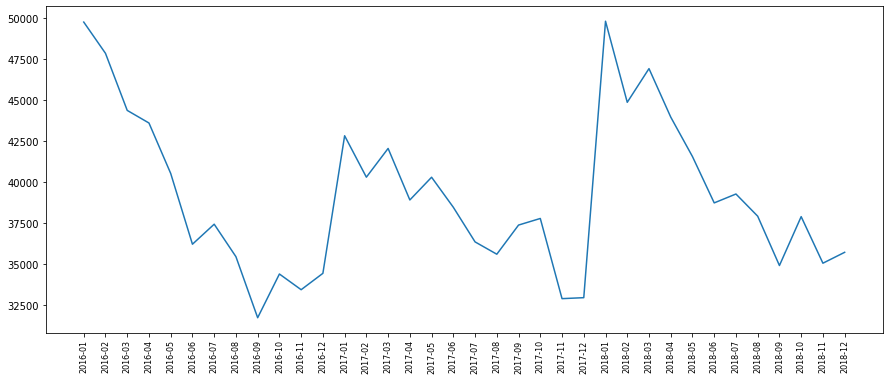

In [300]:
plt.figure(figsize=(15,6))
plt.plot(train_trend['bulantahun'], train_trend['qty'])
plt.xticks(rotation='vertical', size=8)
plt.show()

In [301]:
train.nunique()

qty            122
kodejenis       56
barcode       1368
date          1093
month_yr        36
bulantahun      36
dtype: int64

In [303]:
# top 10 most selling poducts
prod_sales = pd.DataFrame(train.groupby('barcode').sum()['qty'])

In [304]:
prod_sales = prod_sales.sort_values('qty', ascending=False)

In [305]:
prod_sales[:10]

,qty
barcode,
8999999706180,24335
8999999706173,20605
8999999390198,19738
8999999706081,16006
8999999050009,15771
8999999390181,14900
8999999059316,14272
8999999047221,14150
8999999059323,14100


In [306]:
daily_sales = train.groupby("date", as_index=False)['qty'].sum()
# store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['barcode', 'date'], as_index=False)['qty'].sum()

In [307]:
# dail sales

daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['qty'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [308]:
# daily sales by item
item_daily_sales_sc = []
for item in item_daily_sales['barcode'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['barcode'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['qty'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [309]:
train['month_yr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [310]:
print(f"Min date from data set: {test['date'].min().date()}")
print(f"Max date from data set: {test['date'].max().date()}")

Min date from data set: 2019-01-01
Max date from data set: 2019-12-31


In [311]:
print(f"Min date from data set: {train['date'].min().date()}")
print(f"Max date from data set: {train['date'].max().date()}")

Min date from data set: 2016-01-01
Max date from data set: 2018-12-31


In [312]:
# a